In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class Residual_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, stride=1,downsample=None):
        super(Residual_block, self).__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels=in_channels,kernel_size=3,out_channels=out_channels,padding=1,stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(in_channels=out_channels,kernel_size=3,out_channels=out_channels,padding=1,stride=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
    def forward(self,x):
        res = x
        #print("Input x dimensions:", x.size())
        x = self.conv1(x)#####

        x = self.bn1(x)
        
        x = self.relu(x)#F(x) = H(X)-Xの状態
        
        x = self.conv2(x)####
        x = self.bn2(x)
        #print("pre-ouputdimensions:",x.size())
        if(self.downsample is not None):
            #print("downsample")
            res = self.downsample(res)
        x = res + x#F(X)+X = H(X)　次元数があってない場合の場合分けが必要
        x = self.relu(x)##微分された結果が全部伝搬される
        return x

In [3]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet,self).__init__()
        #self.conv1 = nn.Conv2d(kernel_size=7,in_channels=3,out_channels=64,stride=2,padding=3)#一層目なぜpadding3?
        self.conv1 = nn.Conv2d(kernel_size=3,in_channels=3,out_channels=64,stride=2,padding=3) #cifar-10の場合
        self.bn = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size = 3,stride=2,padding=1)
        self.conv2_1 = Residual_block(in_channels=64,out_channels=64)
        self.conv2_2 = Residual_block(in_channels=64,out_channels=64)
        self.conv3_1 = Residual_block(in_channels=64,out_channels=128,stride=2,downsample=nn.Conv2d(kernel_size=1,in_channels=64,out_channels=128,padding=0,stride=2,bias=False)) #1*1で畳み込みチャネル数を変更 
        self.conv3_2 = Residual_block(in_channels=128,out_channels=128)
        self.conv4_1 = Residual_block(in_channels=128,out_channels=256,stride=2,downsample=nn.Conv2d(kernel_size=1,in_channels=128,out_channels=256,padding=0,stride=2,bias=False))#1*1で畳み込みチャネル数を変更
        self.conv4_2 = Residual_block(in_channels=256,out_channels=256)
        self.conv5_1 = Residual_block(in_channels=256,out_channels=512,stride=2,downsample=nn.Conv2d(kernel_size=1,in_channels=256,out_channels=512,padding=0,stride=2,bias=False))#1*1で畳み込みチャネル数を変更
        self.conv5_2 = Residual_block(in_channels=512,out_channels=512)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))#inchaenl に合わせてpoolingされる
        self.fc = nn.Linear(512,10)
        return 
    def forward(self,x):#順伝搬　xが入力最悪ここに直書きしてもできそうではある。
        x = self.conv1(x)
        x =self.pool1(x)
        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv4_1(x)
        x = self.conv4_2(x)
        x = self.conv5_1(x)
        x = self.conv5_2(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)##ここのreshapeがなぜか重要
        x = self.fc(x)
        return x

In [10]:
from torchinfo import summary
batch_size=128
model = ResNet()
model
summary(model,
        input_size=(batch_size,3,32,32)
        )

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 10]                 128
├─Conv2d: 1-1                            [128, 64, 18, 18]         1,792
├─MaxPool2d: 1-2                         [128, 64, 9, 9]           --
├─Residual_block: 1-3                    [128, 64, 9, 9]           --
│    └─Conv2d: 2-1                       [128, 64, 9, 9]           36,928
│    └─BatchNorm2d: 2-2                  [128, 64, 9, 9]           128
│    └─ReLU: 2-3                         [128, 64, 9, 9]           --
│    └─Conv2d: 2-4                       [128, 64, 9, 9]           36,928
│    └─BatchNorm2d: 2-5                  [128, 64, 9, 9]           128
│    └─ReLU: 2-6                         [128, 64, 9, 9]           --
├─Residual_block: 1-4                    [128, 64, 9, 9]           --
│    └─Conv2d: 2-7                       [128, 64, 9, 9]           36,928
│    └─BatchNorm2d: 2-8                  [128, 64, 9, 9]           

In [5]:
train_data = datasets.CIFAR10('./data', #データを保存するdir
                              train = True,  #True : 学習用データ False : テストデータ 
                              download=True,  # downloadするか否か
                              transform = transforms.Compose([transforms.ToTensor()]) #前処理の設定
                              )
train_loader = DataLoader(train_data,batch_size=64)
#32*32の3チャネル画像

Files already downloaded and verified


In [5]:
def load_cifar10(batch=256):
    train_loader = DataLoader(
        datasets.CIFAR10('./data',
                         train=True,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                [0.5, 0.5, 0.5],  # RGB 平均
                                [0.5, 0.5, 0.5]   # RGB 標準偏差
                                )
                         ])),
        batch_size=batch,
        shuffle=True
    )

    test_loader = DataLoader(
        datasets.CIFAR10('./data',
                         train=False,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                 [0.5, 0.5, 0.5],  # RGB 平均
                                 [0.5, 0.5, 0.5]  # RGB 標準偏差
                             )
                         ])),
        batch_size=batch,
        shuffle=True
    )

    return {'train': train_loader, 'test': test_loader}

In [6]:
if __name__ == '__main__':
    epoch = 100
    
    loader = load_cifar10()
    classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')

    net = ResNet()
    criterion = torch.nn.CrossEntropyLoss()  # ロスの計算
    optimizer = torch.optim.SGD(params=net.parameters(), lr=0.001, momentum=0.9)#lr=学習率,

    # 学習前のフィルタの可視化
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net.to(device)
    print(device)
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_acc': [],
        'iter_loss':[],
    }


    for e in range(epoch):
        net.train()
        loss = None
        for i, (images, labels) in enumerate(loader['train']):
            images = images.to(device)  # to GPU?
            labels = labels.to(device)
            optimizer.zero_grad()#パラメータの初期化
            output = net(images)
            loss = criterion(output, labels)
            loss.backward()#lossを逆伝搬
            optimizer.step()
            history['iter_loss'].append(loss.item())

            if i % 10 == 0:
                print('Training log: {} epoch ({} / 50000 train. data). Loss: {}'.format(e + 1,
                                                                                         (i + 1) * 128,
                                                                                         loss.item())
                      )


        history['train_loss'].append(loss.item())


100%|██████████| 170498071/170498071 [00:43<00:00, 3916953.73it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
cuda:0
Training log: 1 epoch (128 / 50000 train. data). Loss: 2.3529584407806396
Training log: 1 epoch (1408 / 50000 train. data). Loss: 2.228349447250366
Training log: 1 epoch (2688 / 50000 train. data). Loss: 2.0862884521484375
Training log: 1 epoch (3968 / 50000 train. data). Loss: 1.9271612167358398
Training log: 1 epoch (5248 / 50000 train. data). Loss: 1.7400344610214233
Training log: 1 epoch (6528 / 50000 train. data). Loss: 1.6952229738235474
Training log: 1 epoch (7808 / 50000 train. data). Loss: 1.6109296083450317
Training log: 1 epoch (9088 / 50000 train. data). Loss: 1.5449740886688232
Training log: 1 epoch (10368 / 50000 train. data). Loss: 1.4516798257827759
Training log: 1 epoch (11648 / 50000 train. data). Loss: 1.5245981216430664
Training log: 1 epoch (12928 / 50000 train. data). Loss: 1.4414910078048706
Training log: 1 epoch (14208 / 50000 train. data). Loss: 1.49853515625
Trainin

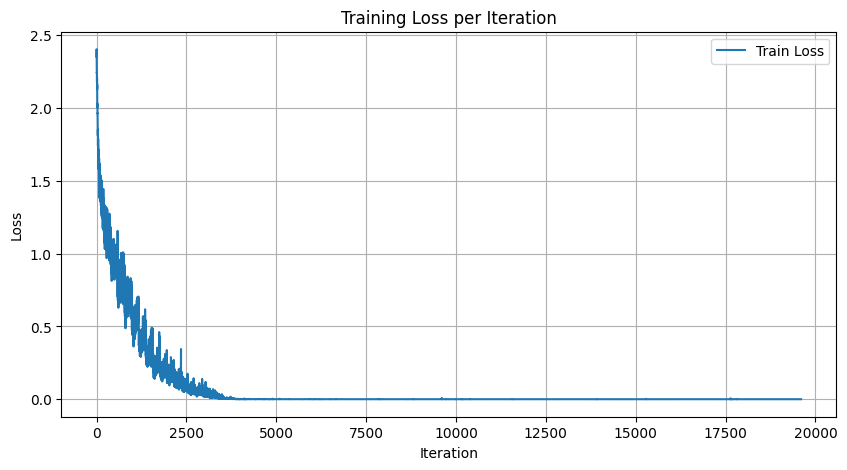

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(history["iter_loss"], label='Train Loss')
plt.title('Training Loss per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

100%|██████████| 40/40 [00:01<00:00, 25.46it/s]


"plt.plot(range(1, epoch + 1), history['train_acc'], label='train_acc')\nplt.plot(range(1, epoch + 1), history['test_acc'], label='test_acc')\nplt.title('Accuracies [CIFAR10]')\nplt.xlabel('epoch')\nplt.ylabel('accuracy')\nplt.legend()\nplt.savefig('img/cifar10_acc.png')\nplt.close()"

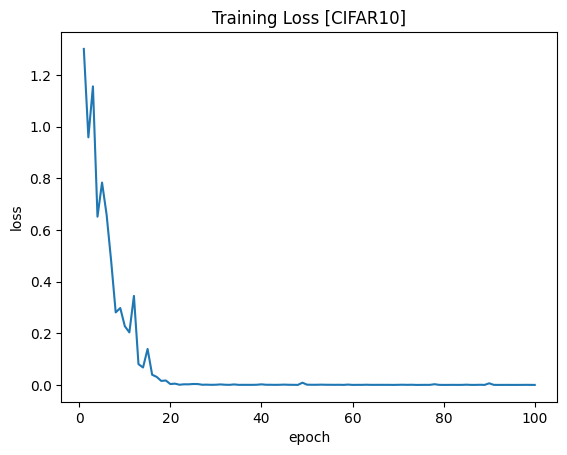

In [8]:
from tqdm import tqdm
import matplotlib.pyplot as plt
net.eval()
correct = 0
with torch.no_grad():
    for i, (images, labels) in enumerate(tqdm(loader['train'])):
        images = images.to(device)  # to GPU?
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

acc = float(correct / 50000)
history['train_acc'].append(acc)

correct = 0
with torch.no_grad():
    for i, (images, labels) in enumerate(tqdm(loader['test'])):
        images = images.to(device)  # to GPU?
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

acc = float(correct / 10000)
history['test_acc'].append(acc)

# 結果をプロット
plt.plot(range(1, epoch+1), history['train_loss'])
plt.title('Training Loss [CIFAR10]')
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.savefig('img/cifar10_loss.png')
#plt.close()

"""plt.plot(range(1, epoch + 1), history['train_acc'], label='train_acc')
plt.plot(range(1, epoch + 1), history['test_acc'], label='test_acc')
plt.title('Accuracies [CIFAR10]')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('img/cifar10_acc.png')
plt.close()"""

ValueError: x and y must have same first dimension, but have shapes (100,) and (1,)

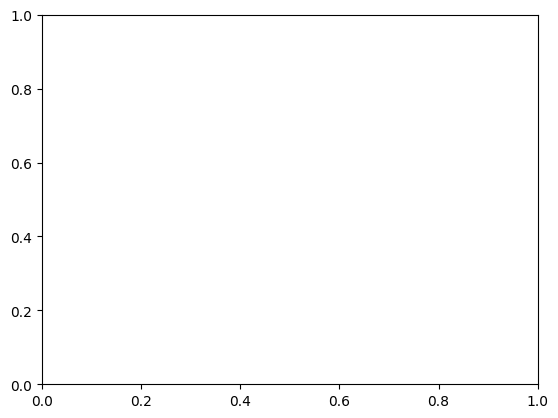

In [9]:
plt.plot(range(1, epoch + 1), history['train_acc'], label='train_acc')
plt.plot(range(1, epoch + 1), history['test_acc'], label='test_acc')
plt.title('Accuracies [CIFAR10]')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

In [35]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

# データのダミー
inputs = torch.randn(batch_size, 3, 224, 224)
targets = torch.randint(0, 10, (batch_size,))

# 訓練モード
model.train()
for epoch in range(10):  # 10エポック
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = nn.functional.cross_entropy(outputs, targets)
    loss.backward()
    optimizer.step()


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [25]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Residual_block(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (con2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2_2): Residual_block(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (con2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3_1): Residual_block(
    (conv1): Conv2d(64, 128, kern

参考
https://udemy.benesse.co.jp/development/python-work/pytorch.html
https://qiita.com/mathlive/items/8e1f9a8467fff8dfd03c
https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module
chat-gpt　pytorchの使い方について聞きました
-----------------------------------------------------------------------------------
self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU() +X
        )
多数レイヤーの記述方法　これの2回目のreluの前に残差を足せればOK
------------------------------------------------------------
カスタム層が作れるらしい make layer 
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=1, stride=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.layer1 = ConvBlock(3, 32, 3)  # 3チャンネル入力、32チャンネル出力、3x3カーネル
        self.layer2 = ConvBlock(32, 64, 3) # 32チャンネル入力、64チャンネル出力、3x3カーネル
        self.layer3 = ConvBlock(64, 128, 3) # 64チャンネル入力、128チャンネル出力、3x3カーネル

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x
----------------------------------------------------------------